In [3]:
import os
import cv2 as cv
import numpy as np

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt

from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

cuda


In [4]:
# Loading the images

IMG_FOLDER = "../data/images/train"
IMG_FILES = os.listdir(IMG_FOLDER)

In [5]:
W = 15
ALPHA = 0.4
OMEGA = 0.75

In [6]:
# Define a class for the pooling operation

class Pool2D(nn.Module):
    def __init__(self, kernel_size, mode, stride=1):
        super(Pool2D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = kernel_size // 2
        self.mode = mode
        assert(self.mode in ['max', 'min'])
        self.max_pool = nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        
    def forward(self, x):
        if self.mode == 'min':
            x = -x
            
        x_gpu = torch.tensor(x, dtype=torch.float32).to(device)
        x_gpu = x_gpu.permute(2, 0, 1).unsqueeze(0)
        x_gpu = self.max_pool(x_gpu)
        x_gpu = x_gpu.squeeze(0).permute(1, 2, 0)
        x_cpu = x_gpu.cpu().detach().numpy()
        x_cpu_max = np.max(x_cpu, axis=2)
        
        if(self.mode == 'min'):
            x_cpu_max = -x_cpu_max
            
        return x_cpu_max
    
max_pool = Pool2D(W, 'max')
min_pool = Pool2D(W, 'min')
    
def get_illumination_channels(img, w):
    width, height, _ = img.shape

    dark_channel = min_pool.forward(img)
    bright_channel = max_pool.forward(img)
    
    assert(dark_channel.shape == (width, height))
    
    return dark_channel, bright_channel

In [7]:
# Getting the atmosphere values

def get_atmosphere(I, img_bright, p):
    """
    Estimates the atmospheric light value A from the input image and its bright channel.

    Args:
        I (numpy.ndarray): The input image.
        img_bright (numpy.ndarray): The bright channel of the input image.
        p (float): The percentage of the brightest pixels to consider.

    Returns:
        numpy.ndarray: The estimated atmospheric light value.
    """
    width, height = img_bright.shape

    # Flatten the image and bright channel
    flat_image = I.reshape(width * height, 3)
    flat_bright = img_bright.reshape(width * height)

    # Get indices of the top p% brightest pixels
    search_index = np.argsort(flat_bright)[::-1][:int(p * width * height)]
    brightest_pixels = flat_image[search_index]

    # Compute the mean of the brightest pixels to estimate atmospheric light
    A = np.mean(brightest_pixels, axis=0, dtype=np.float64)
    
    return A

In [8]:
# Getting the initial transmission map

def get_initial_transmission_map(A, bright_channel):
    """
    Compute the initial transmission map based on the estimated atmospheric light value and the bright channel.
    
    Args:
        A (numpy.ndarray): The estimated atmospheric light value.
        bright_channel (numpy.ndarray): The bright channel of the input image.
    
    Returns:
        numpy.ndarray: The normalized initial transmission map.
    """
    # Compute the maximum value of the estimated atmospheric light
    A_c = np.max(A)
    
    # Compute the initial transmission map
    init_t = (bright_channel - A_c) / (1.0 - A_c)
    
    # Normalize the initial transmission map to the range [0, 1]
    normalized_t = (init_t - np.min(init_t)) / (np.max(init_t) - np.min(init_t))
    
    return normalized_t

In [9]:
# Getting the refined transmission map

def get_refined_transmission_map(img, A, img_dark, img_bright, init_t, alpha, omega, w):
    img_n = np.empty(img.shape, dtype=img.dtype)
    
    for channel in range(0, 3):
        img_n[:, :, channel] = img[:, :, channel] / A[channel]
        
    img_dark_n, _ = get_illumination_channels(img_n, w)
    dark_t = 1 - omega * img_dark_n
    
    diff_channel = img_bright - img_dark
    
    mask_t = diff_channel < alpha
    
    # if mask = 1 use dark_t * init_t else use init_t
    corrected_t = np.where(mask_t, dark_t * init_t, init_t)
    
    return np.abs(corrected_t)

In [11]:
img = cv.imread(os.path.join(IMG_FOLDER, IMG_FILES[0]))

print(img.shape)
print(img.dtype)

img = np.asarray(img, dtype=np.float64)
img /= 255

(4032, 3024, 3)
uint8


In [12]:
dark_channel, bright_channel = get_illumination_channels(img, W)

print(dark_channel.shape)
print(bright_channel.shape)

print(np.min(dark_channel), np.max(dark_channel))
print(np.min(bright_channel), np.max(bright_channel))



(4032, 3024)
(4032, 3024)
0.0 0.14117648
0.047058824 0.23921569


In [13]:
print(dark_channel.dtype, bright_channel.dtype)
print(np.min(dark_channel), np.max(dark_channel))

atmosphere = get_atmosphere(img, bright_channel, 0.1)

print(atmosphere)

normalized = get_initial_transmission_map(atmosphere, bright_channel)

print(normalized.shape)
print(np.min(normalized), np.max(normalized))

float32 float32
0.0 0.14117648
[0.14183599 0.15436044 0.16802605]
(4032, 3024)
0.0 1.0


(4032, 3024)


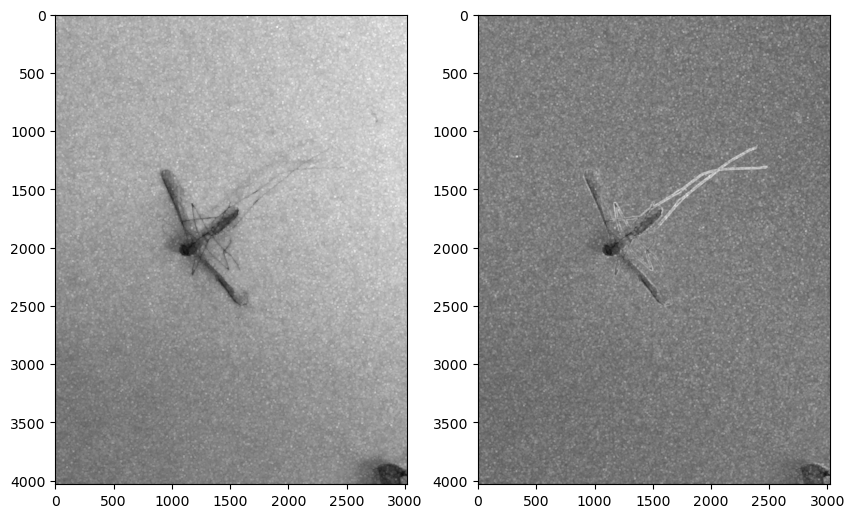

In [14]:
corrected_t = get_refined_transmission_map(img, atmosphere, dark_channel, bright_channel, normalized, ALPHA, OMEGA, W)

print(corrected_t.shape)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(normalized, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(corrected_t, cmap='gray')

plt.show()

In [23]:
img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))

print(img_norm.shape, corrected_t.shape)

refined_t = guided_filter(img_norm, corrected_t, W, 1e-3)

(4032, 3024, 3) (4032, 3024)


KeyboardInterrupt: 